In [31]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [32]:
# Rango HSV para azules
lower_blue = np.array([ 90,  80,  40]) 
upper_blue = np.array([150, 255, 255]) 

(np.float64(-0.5), np.float64(2249.5), np.float64(675.5), np.float64(-0.5))

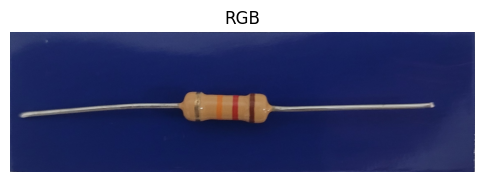

In [33]:
ruta = 'resistencias_out/R5_a_out.jpg'
img_bgr = cv2.imread(ruta)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 4))
plt.imshow(img_rgb)
plt.title('RGB')
plt.axis('off')

(np.float64(-0.5), np.float64(2249.5), np.float64(675.5), np.float64(-0.5))

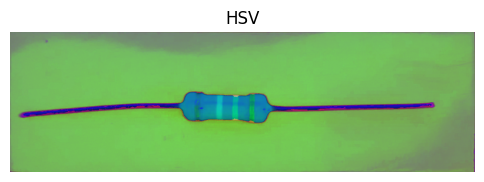

In [34]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(6, 4))
plt.imshow(img_hsv)
plt.title('HSV')
plt.axis('off')

(np.float64(-0.5), np.float64(2249.5), np.float64(675.5), np.float64(-0.5))

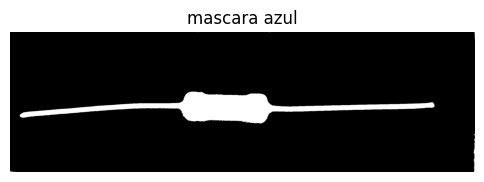

In [35]:
# Create mask to isolate resistor (non-blue regions)
mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
mask = cv2.bitwise_not(mask)  # Invert mask to get resistor
plt.figure(figsize=(6, 4))
plt.imshow(mask, cmap = 'gray')
plt.title('mascara azul')
plt.axis('off')

(np.float64(-0.5), np.float64(2249.5), np.float64(675.5), np.float64(-0.5))

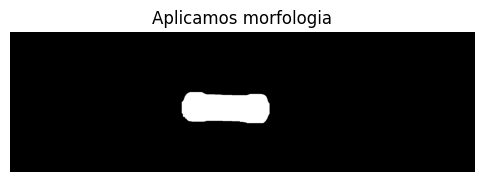

In [36]:
# Aplicamos morfología - Apertura y clausura
kernel_clausura = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
kernel_apertura = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
mascara_clausura = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_clausura, iterations=2)
mascara_apertura = cv2.morphologyEx(mascara_clausura, cv2.MORPH_OPEN, kernel_apertura, iterations=1)
plt.figure(figsize=(6, 4))
plt.imshow(mascara_apertura, cmap='gray')
plt.title('Aplicamos morfologia')
plt.axis('off')

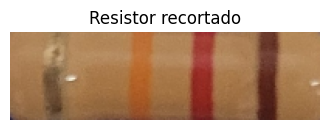

In [37]:
# Find contours to locate the resistor
contornos, _ = cv2.findContours(mascara_apertura, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cont_max = max(contornos, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cont_max)

padding = 20
x = x + padding
y = y + padding
w = w - 2 * padding
h = h - 2 * padding

resistor_roi = img_bgr[y:y+h, x:x+w]


# Resize ROI to a standard width for consistent band detection
standard_width = 200
aspect_ratio = h / w
standard_height = int(standard_width * aspect_ratio)
resized_roi = cv2.resize(resistor_roi, (standard_width, standard_height))

resized_roi_rgb = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2RGB)

# Mostrar la imagen recortada
plt.figure(figsize=(4, 4))
plt.imshow(resized_roi_rgb)
plt.title('Resistor recortado')
plt.axis('off')
plt.show()


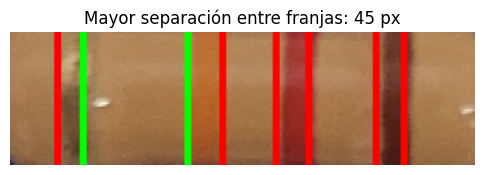

In [42]:
# 8. Agrupar bordes en pares (franjas)
franjas_pares = []
for i in range(0, len(franjas) - 1, 2):
    franjas_pares.append((franjas[i], franjas[i+1]))

# 9. Calcular distancias entre bordes consecutivos
distancias = []
for i in range(1, len(franjas) - 2, 2):
    fin_actual = franjas[i]     # borde derecho de banda i//2
    inicio_siguiente = franjas[i + 1]  # borde izquierdo de banda (i//2 + 1)
    distancia = inicio_siguiente - fin_actual
    distancias.append((i, fin_actual, inicio_siguiente, distancia))  # i = índice del borde izquierdo de la separación

# 10. Buscar la mayor distancia entre bordes consecutivos
mayor_distancia = max(distancias, key=lambda x: x[3])

# 11. Determinar la banda más alejada (la franja dorada)
indice_borde = mayor_distancia[0]  # borde derecho de una banda (franjas[i])
indice_banda_dorada = (indice_borde - 1) // 2  # índice de la banda anterior a la separación

franja_dorada = franjas_pares[indice_banda_dorada]
franjas_colores = [f for i, f in enumerate(franjas_pares) if i != indice_banda_dorada]

# Detección izquierda o derecha (para ordenado visual)
posicion_dorada = 'izquierda' if indice_banda_dorada == 0 else 'derecha' if indice_banda_dorada == len(franjas_pares) - 1 else 'medio'
if posicion_dorada == 'medio':
    print(f"⚠️ La franja dorada no está en un extremo: índice {indice_banda_dorada}. Se considera igualmente válida.")

# 12. Dibujar separación más grande
img_distancia = img_franjas.copy()
cv2.line(img_distancia, (mayor_distancia[1], 0), (mayor_distancia[1], img_franjas.shape[0]), (0, 255, 0), 2)
cv2.line(img_distancia, (mayor_distancia[2], 0), (mayor_distancia[2], img_franjas.shape[0]), (0, 255, 0), 2)

plt.figure(figsize=(6, 4))
plt.imshow(img_distancia)
plt.title(f'Mayor separación entre franjas: {mayor_distancia[3]} px')
plt.axis('off')
plt.show()




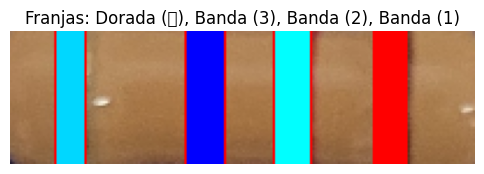

In [47]:
# Calcular centro de la franja dorada
centro_dorada = (franja_dorada[0] + franja_dorada[1]) // 2

# Calcular distancia de cada franja a la dorada
franjas_con_distancia = []
for franja in franjas_colores:
    centro_franja = (franja[0] + franja[1]) // 2
    distancia = abs(centro_franja - centro_dorada)
    franjas_con_distancia.append((distancia, franja))

# Ordenar de más lejana a más cercana
franjas_ordenadas = sorted(franjas_con_distancia, key=lambda x: -x[0])  # orden descendente

# Asignar bandas según cercanía a la dorada
banda1 = franjas_ordenadas[0][1]  # más lejana
banda2 = franjas_ordenadas[1][1]
banda3 = franjas_ordenadas[2][1]  # más cercana

# Dorada
cv2.rectangle(img_coloreada, (franja_dorada[0], 0), (franja_dorada[1], img_franjas.shape[0]), (0, 215, 255), -1)  # dorado

# Banda 1 (más lejana)
cv2.rectangle(img_coloreada, (banda1[0], 0), (banda1[1], img_franjas.shape[0]), (255, 0, 0), -1)  # azul
# Banda 2 (media)
cv2.rectangle(img_coloreada, (banda2[0], 0), (banda2[1], img_franjas.shape[0]), (0, 255, 255), -1)  # amarillo
# Banda 3 (más cercana)
cv2.rectangle(img_coloreada, (banda3[0], 0), (banda3[1], img_franjas.shape[0]), (0, 0, 255), -1)  # rojo

plt.figure(figsize=(6, 4))
plt.imshow(img_coloreada)
plt.title(f'Franjas: Dorada (🟨), Banda (3), Banda (2), Banda (1)')
plt.axis('off')
plt.show()